In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [4]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/mLND3-1_v4.h5ad')
adata

AnnData object with n_obs × n_vars = 15836 × 3140
    obs: 'cluster', 'rctd_cluster', 'cell_type', 'cell_type_int'
    var: 'n_counts'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

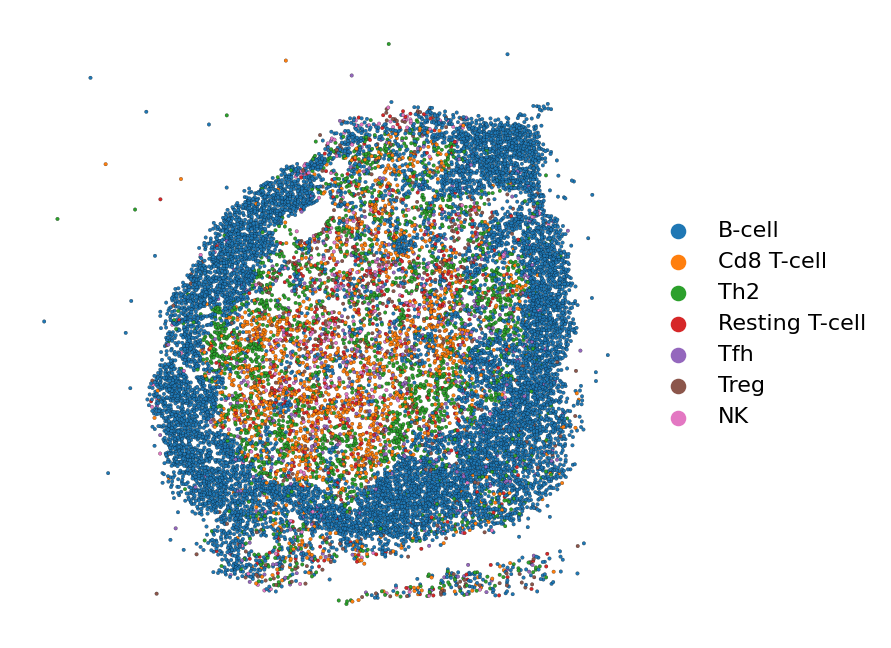

In [5]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams['figure.dpi'] = 160
sc.pl.embedding(adata, basis='spatial', color='cell_type', 
    frameon=False, edgecolor='black', s=10, linewidth=0.1, title='')


In [6]:
import sys
sys.path.append('/Users/koush/Projects/SpaceOracle/src/')

In [7]:
import celloracle as co

%matplotlib inline
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams['figure.dpi'] = 180

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [8]:
%%time

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
sc.tl.umap(adata)
# sc.tl.leiden(adata, resolution=0.5)

CPU times: user 38.7 s, sys: 9.16 s, total: 47.9 s
Wall time: 34.7 s


In [9]:
adata.X.max()

521.0

In [10]:
adata.layers["raw_count"].max()

521.0

In [11]:
adata

AnnData object with n_obs × n_vars = 15836 × 3140
    obs: 'cluster', 'rctd_cluster', 'cell_type', 'cell_type_int'
    var: 'n_counts'
    uns: 'cell_type_colors', 'pca', 'neighbors', 'umap'
    obsm: 'X_spatial', 'rctd_results', 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'distances', 'connectivities'

In [12]:
oracle = co.Oracle()

adata.X = adata.layers["raw_count"].copy()

oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="cell_type",
    embedding_name="X_umap"
)

oracle.pcs = [True]
oracle.k_knn_imputation = 1
oracle.knn = 1

In [13]:
base_GRN = co.data.load_mouse_promoter_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

Loading prebuilt promoter base-GRN. Version: mm10_gimmemotifsv5_fpr2


In [14]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="cell_type", 
    alpha=10,
    verbose_level=2
)

  0%|          | 0/7 [00:00<?, ?it/s]

Inferring GRN for B-cell...


  0%|          | 0/2939 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [04:55<29:33, 295.61s/it]

Inferring GRN for Cd8 T-cell...


  0%|          | 0/2939 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [06:27<14:38, 175.64s/it]

Inferring GRN for NK...


  0%|          | 0/2939 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [07:54<09:01, 135.44s/it]

Inferring GRN for Resting T-cell...


  0%|          | 0/2939 [00:00<?, ?it/s]

 57%|█████▋    | 4/7 [09:22<05:49, 116.65s/it]

Inferring GRN for Tfh...


  0%|          | 0/2939 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [10:50<03:32, 106.25s/it]

Inferring GRN for Th2...


  0%|          | 0/2939 [00:00<?, ?it/s]

 86%|████████▌ | 6/7 [12:24<01:41, 101.99s/it]

Inferring GRN for Treg...


  0%|          | 0/2939 [00:00<?, ?it/s]

100%|██████████| 7/7 [13:52<00:00, 118.88s/it]

CPU times: user 7min 48s, sys: 27.1 s, total: 8min 15s
Wall time: 13min 52s


In [15]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(
    alpha=10, 
    use_cluster_specific_TFdict=True
)

  0%|          | 0/7 [00:00<?, ?it/s]

In [16]:
import pickle

with open('/Users/koush/Desktop/training_data/mLND3-1_v4_colinks.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)

In [17]:
adata

AnnData object with n_obs × n_vars = 15836 × 3140
    obs: 'cluster', 'rctd_cluster', 'cell_type', 'cell_type_int'
    var: 'n_counts'
    uns: 'cell_type_colors', 'pca', 'neighbors', 'umap'
    obsm: 'X_spatial', 'rctd_results', 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'distances', 'connectivities'

In [18]:
links.links_dict.keys()

dict_keys(['B-cell', 'Cd8 T-cell', 'NK', 'Resting T-cell', 'Tfh', 'Th2', 'Treg'])